In [145]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr
from src.viz import Plot

from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [151]:
parameters = dict(years_train=list(range(2010, 2012)),
                  years_test=[2013],
                  X_vars=['icethic_cea', 'vosaline'],
                  y_var='hice',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20],
                  dx=5,
                  dy=5,
                  dt=5,
                  n_neurons=20,
                  epochs=70,
                  batch_size=30,
                  loss='mae'
                  )

y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])

In [201]:
X_train = np.array(X_arr_train)
y_train = np.array(y_arr_train)
X_train=np.moveaxis(X_train,0,-1)
y_train.shape



(730, 452, 406)

In [202]:
scalers = []
for i in range(X_train.shape[0]):
#     y_train[i,:,:,:] = MinMaxScaler().fit_transform(y_train[i,:,:,:])
    
    
    for j in range(X_train.shape[-1]):
        sc = MinMaxScaler(feature_range=(-1, 1))
        scalers.append(sc)
        X_train[i,:,:,j] = sc.fit_transform(X_train[i,:,:,j])
        y_train[i,:,:] = sc.fit_transform(y_train[i,:,:])

In [212]:
y_train = y_train[:,:,:,np.newaxis]
X_val = X_train[100:110,:,:,:]
y_val = y_train[100:110,:,:,:]

X_test = X_train[110:120,:,:,:]
y_test = y_train[110:120,:,:,:]

X_train = X_train[120:130,:,:,:]
y_train = y_train[120:130,:,:,:]

In [213]:
y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0
y_val[np.isnan(y_val)] = 0


In [146]:
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test)

X_val = scaler.transform(X_val)
y_val = scaler.transform(y_val)

X_train = scaler.transform(X_train)
y_train = scaler.transform(y_train)

ValueError: Found array with dim 4. MinMaxScaler expected <= 2.

In [163]:
from keras.models import *
from keras.layers import *

def rainnet(input_shape=(384, 384, 2), mode="regression"):
    """
    The function for building the RainNet (v1.0) model from scratch
    using Keras functional API.
    Parameters:
    input size: tuple(W x H x C), where W (width) and H (height)
    describe spatial dimensions of input data (e.g., 928x928 for RY data);
    and C (channels) describes temporal (depth) dimension of 
    input data (e.g., 4 means accounting four latest radar scans at time
    t-15, t-10, t-5 minutes, and t)
    
    mode: "regression" (default) or "segmentation". 
    For "regression" mode the last activation function is linear, 
    while for "segmentation" it is sigmoid.
    To train RainNet to predict continuous precipitation intensities use 
    "regression" mode. 
    RainNet could be trained to predict the exceedance of specific intensity 
    thresholds. For that purpose, use "segmentation" mode.
    """

    inputs = Input(input_shape)

    conv1f = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1f = Activation("relu")(conv1f)
    conv1s = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1f)
    conv1s = Activation("relu")(conv1s)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1s)

    conv2f = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2f = Activation("relu")(conv2f)
    conv2s = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2f)
    conv2s = Activation("relu")(conv2s)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2s)

    conv3f = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3f = Activation("relu")(conv3f)
    conv3s = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3f)
    conv3s = Activation("relu")(conv3s)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3s)

    conv4f = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4f = Activation("relu")(conv4f)
    conv4s = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4f)
    conv4s = Activation("relu")(conv4s)
    drop4 = Dropout(0.5)(conv4s)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5f = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5f = Activation("relu")(conv5f)
    conv5s = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5f)
    conv5s = Activation("relu")(conv5s)
    drop5 = Dropout(0.5)(conv5s)

    up6 = concatenate([UpSampling2D(size=(2, 2))(drop5), conv4s], axis=3)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3s], axis=3)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Activation("relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2s], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1s], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    if mode == "regression":
        outputs = Conv2D(1, 1, activation='linear')(conv9)
    elif mode == "segmentation":
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [217]:
model = rainnet()
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss="mean_squared_error", metrics=["accuracy"])

In [219]:
res=model.fit(x=X_train[:,:384,:384,:], y=y_train[:,:384,:384,:],
              validation_data=(X_val[:,:384,:384,:],y_val[:,:384,:384,:]),
              batch_size=1,
              epochs=4)

Train on 10 samples, validate on 10 samples
Epoch 1/4
10/10 [==============================] - 67s 7s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/4
10/10 [==============================] - 68s 7s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/4
10/10 [==============================] - 68s 7s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/4
10/10 [==============================] - 69s 7s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [220]:
res = model.predict(X_test[np.newaxis,9,:384,:384,:])

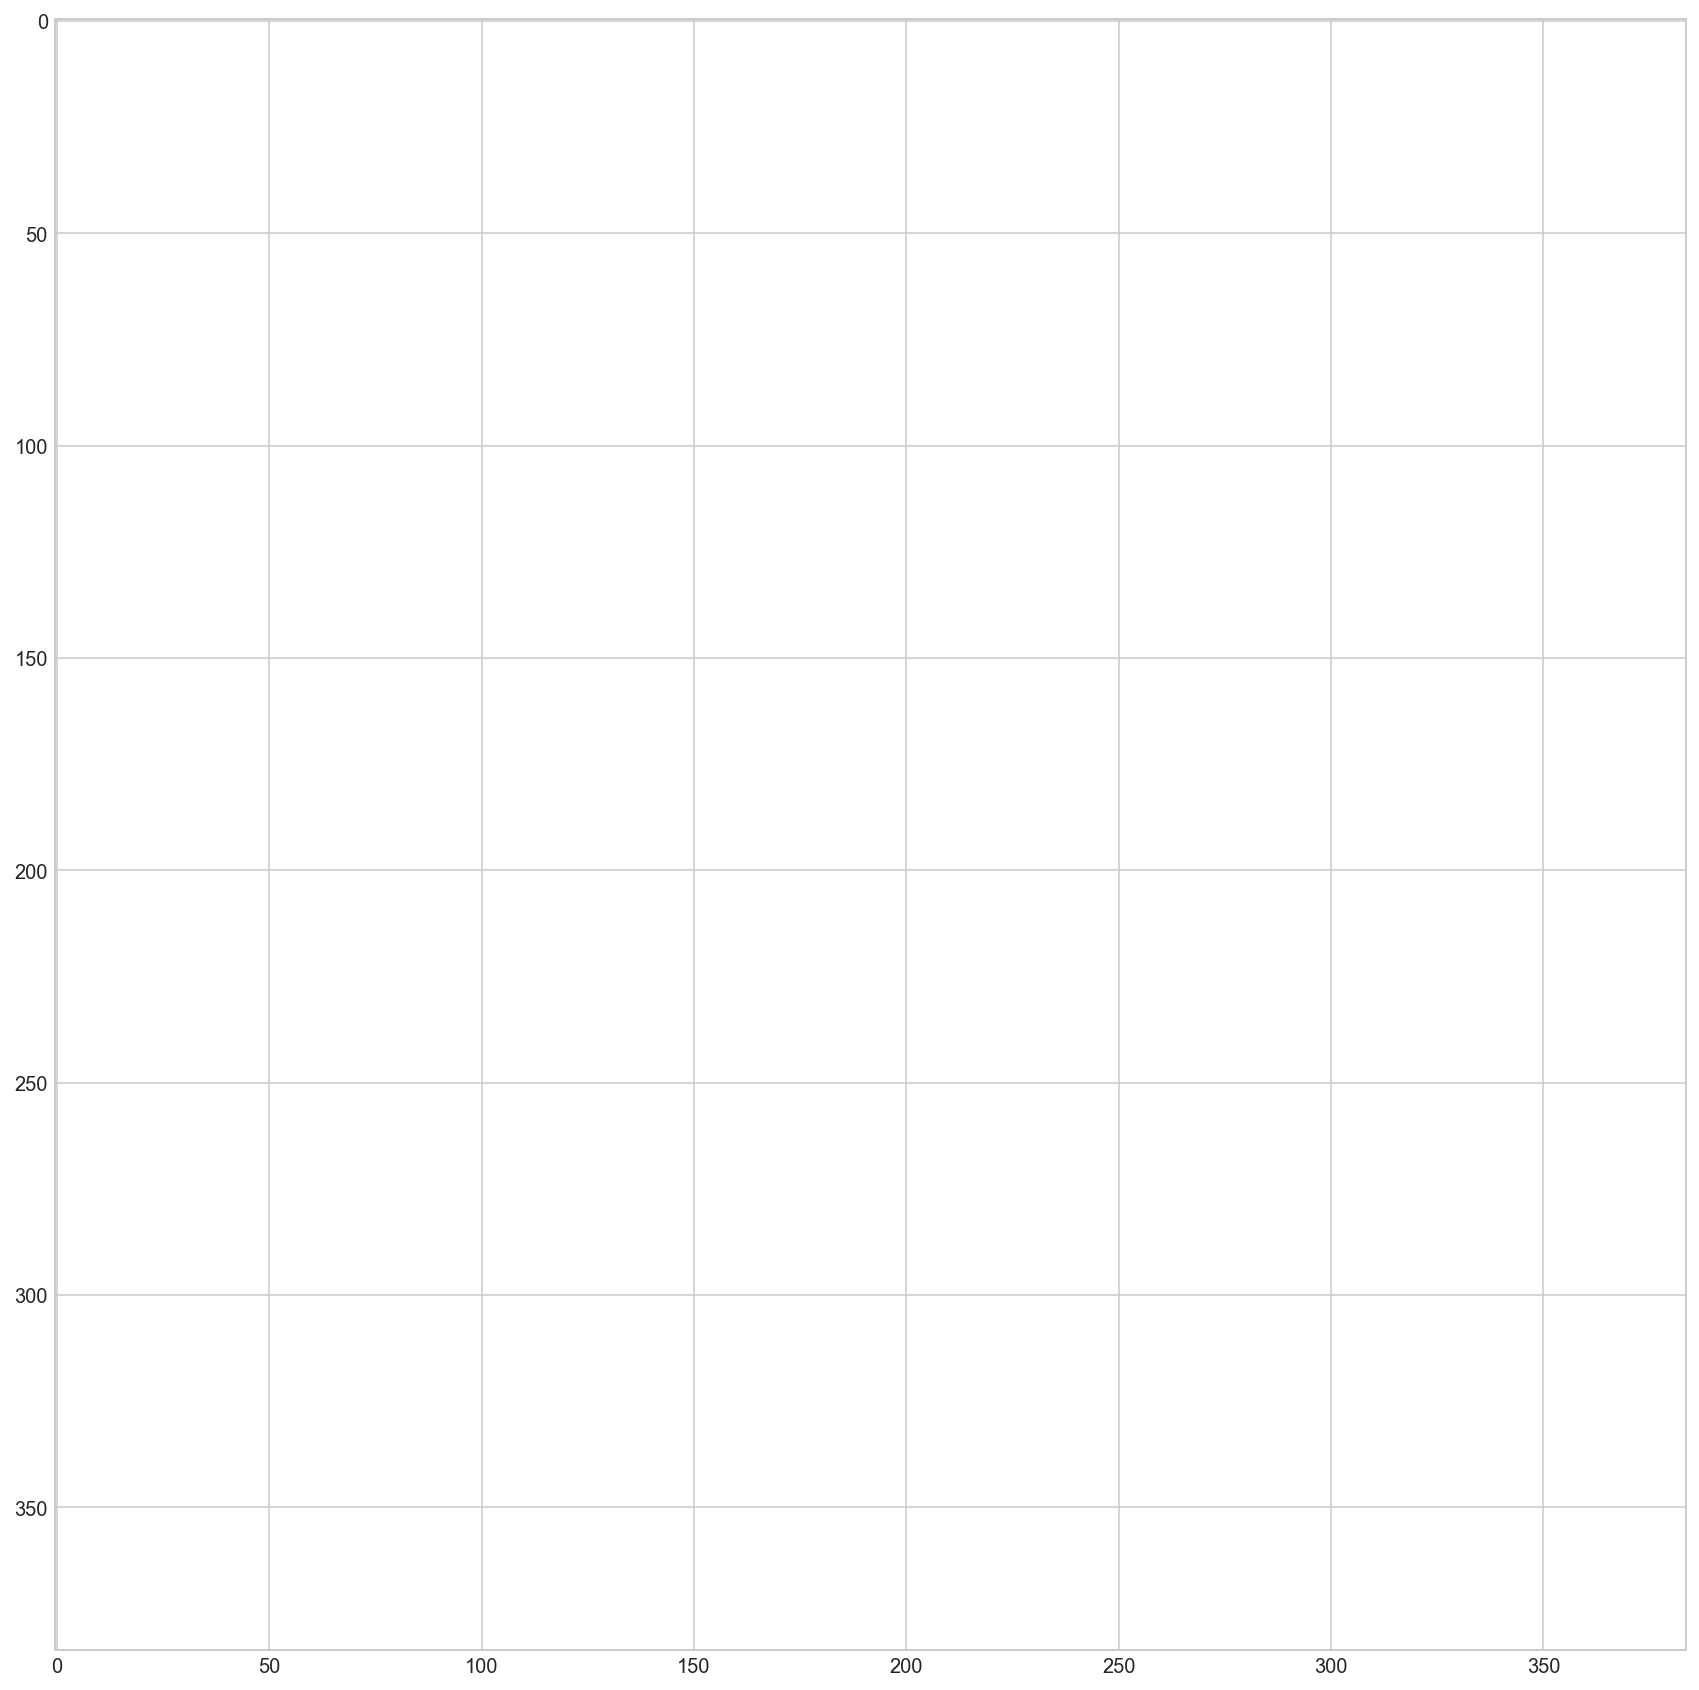

In [231]:
plt.imshow(res[0,:,:,0],vmin=-0.1, vmax=0.1)

In [232]:
res[0,:,:,0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [222]:
np.max(res[0,:,:,0])

nan

In [223]:
X_test[5,:,:,1].mean()

-0.12996127

In [228]:
res.shape

(1, 384, 384, 1)